# 案例分析
# 武汉 - 湖北（除武汉外） - 湖北以外 疫情对比

### 1. 载入数据

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data = utils.load_chinese_data()

最近更新于:  2020-02-08 14:32:33.025000
数据日期范围:  2020-01-24 to 2020-02-08
数据条目数:  24728


In [12]:
daily_frm = utils.aggDaily(data)

### 2. 把数据分成 武汉 -- 湖北（除武汉） -- 全国（除湖北） 三个区域各自整合

In [13]:
wuhan = daily_frm[daily_frm['cityName'] == '武汉'].groupby('updateDate').agg('sum')
hubei_exWuhan = daily_frm[(daily_frm['provinceName'] == '湖北省') & (daily_frm['cityName'] != '武汉')].groupby('updateDate').agg('sum')
china_exHubei = daily_frm[daily_frm['provinceName'] != '湖北省'].groupby('updateDate').agg('sum')

contrast_frm = pd.merge(wuhan.add_suffix('_Wuhan'), hubei_exWuhan.add_suffix('_Hubei_exWuhan'), 'left', on='updateDate')
contrast_frm = pd.merge(contrast_frm, china_exHubei.add_suffix('_China_exHubei'), 'left', on='updateDate')

#### 画图比较确诊人数和死亡人数

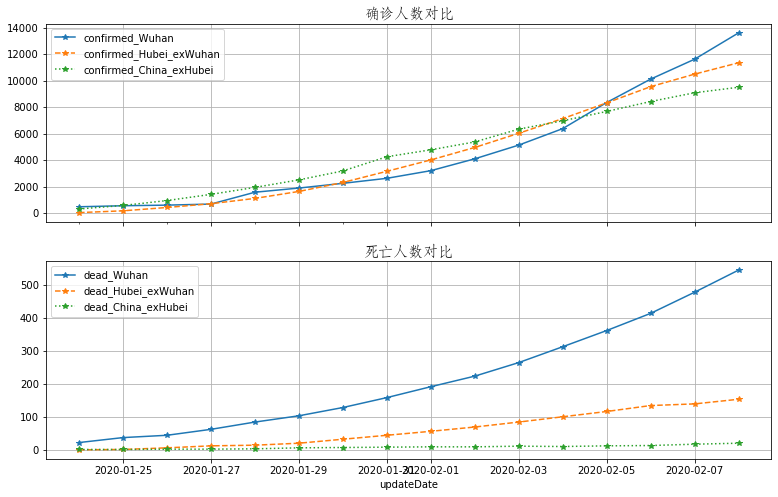

In [14]:
locations = ('Wuhan', 'Hubei_exWuhan', 'China_exHubei')
fig = plt.figure()
ax1 = fig.add_subplot(211)
contrast_frm.plot(y=['confirmed_' + suffix for suffix in locations], grid=True, figsize=(13, 8), style=['-*', '--*', ':*'], ax=ax1)
ax1.set_title('确诊人数对比', fontproperties=utils._FONT_PROP_, fontsize=15)
ax2 = fig.add_subplot(212)
contrast_frm.plot(y=['dead_' + suffix for suffix in locations], grid=True, figsize=(13, 8), style=['-*', '--*', ':*'], ax=ax2, sharex=True)
ax2.set_title('死亡人数对比', fontproperties=utils._FONT_PROP_, fontsize=15)
plt.show()

从上图可以看出，虽然武汉，湖北除武汉，全国除湖北三个区域的确诊人数接近，但是死亡人数却有极大的差异：

武汉 >> 湖北除武汉 >> 全国除湖北

这是为什么呢？

我们定义一个“简单死亡率” (Simple Death Rate)

$$简单死亡率(t) \equiv \frac{死亡人数(t)}{确诊人数(t)}$$

In [15]:
for loc in locations:
    contrast_frm['simpleDeathRate_' + loc] = contrast_frm['dead_' + loc] / contrast_frm['confirmed_' + loc]

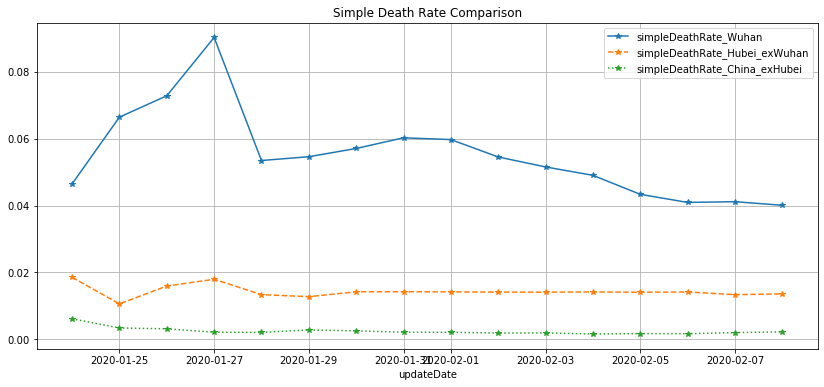

In [16]:
contrast_frm.plot(y=['simpleDeathRate_' + loc for loc in locations], grid=True, figsize=(14, 6), style=['-*', '--*', ':*'],
                 title='Simple Death Rate Comparison')

从上图可以看出，武汉死亡率 > 湖北（除武汉外）死亡率 > 全国其他地区死亡率

这说明武汉死亡人数高不是因为确诊人数多造成的。但是我们知道，死亡人数应该比确诊人数有个滞后，会不会是这个滞后造成计算不准确呢？

In [17]:
def lagDeathRate(df, location, lag=5):
    return np.mean(df['dead_' + location][lag:].to_numpy() / df['confirmed_' + location][:-lag].to_numpy())

In [18]:
print('延迟死亡率')
print('武汉：', "{:.2%}".format(lagDeathRate(contrast_frm, 'Wuhan')))
print('湖北（除武汉）：', "{:.2%}".format(lagDeathRate(contrast_frm, 'Hubei_exWuhan')))
print('全国（除湖北）：', "{:.2%}".format(lagDeathRate(contrast_frm, 'China_exHubei')))

延迟死亡率
武汉： 17.04%
湖北（除武汉）： 9.33%
全国（除湖北）： 0.70%


可见死亡统计的延迟效应并不影响 

武汉死亡率 > 湖北（除武汉外）死亡率 > 全国其他地区死亡率

的结论。

**那么是不是医疗系统饱和造成武汉、湖北死亡率高呢？**